In [1]:
from natgrad.domains import Hyperrectangle, RectangleBoundary, Square
from natgrad.inner import model_laplace, model_identity
from natgrad.derivatives import laplace
from natgrad.integrators import RandomIntegrator
from jax import jit, vmap, random, grad
import jax.numpy as jnp
from natgrad.gram import gram_factory, nat_grad_factory
import natgrad.mlp as mlp    
import jax
import matplotlib.pyplot as plt
from natgrad.plotting import plot_2d_func
from natgrad.utility import grid_line_search_factory

jax.config.update("jax_enable_x64", True)

In [2]:
# Define the domain
# domains
interior = Square(1.) #Polygon(jnp.array([[0,0], [1,0], [0,1]])) # S
boundary = interior.boundary()

# Integrators
seed = 1
key = random.PRNGKey(seed)
weak_integrator = RandomIntegrator(interior, key, 10000)
interior_integrator = RandomIntegrator(interior, key, 100)
boundary_integrator = RandomIntegrator(boundary, key, 100)
eval_integrator = RandomIntegrator(interior, key, 200)

# random seed
freq = 1.
L = 1.
# solution
u_star = jit(lambda xy: jnp.sin(freq * jnp.pi * xy[0] / L) * jnp.sin(freq * jnp.pi * xy[1] / L))
f = jit(lambda xy: 2. * (freq * jnp.pi / L)**2 * u_star(xy))

v_u_star = jit(vmap(u_star, 0))
v_f = jit(vmap(f, 0))

# Weak model
layer_sizes = [2, 32, 1]
activation = lambda x : jnp.tanh(x)
model_weak = mlp.mlp(activation)
v_model_weak = jit(vmap(model_weak, (None, 0)))

#  Obtain new weights
def init_params(key):
    return mlp.init_params(layer_sizes, key)

# Enseble
def model_ensemble(param, x):
    return sum([w * model_weak(p, x) for (p, w) in param])

choice = 2
if choice == 1:
    param = []
    N = 10
    for i in range(N):
        key, subkey = random.split(key)
        param.append((init_params(subkey), 1. / N))
    model = model_ensemble
else:
    param  = init_params(key)
    model = model_weak
    

v_model = jit(vmap(model, (None, 0)))

# Residual functions
def residual_interior(param, x):
    lap = laplace(lambda x: model(param, x))
    return lap(x) + f(x)

def residual_boundary(param, x):
    return model(param, x) - u_star(x)

v_res_interior = jit(vmap(lambda param, x: residual_interior(param, x), (None, 0)))
v_res_boundary = jit(vmap(lambda param, x: residual_boundary(param, x), (None, 0)))
   
@jit
def loss(param):
    interior_loss = interior_integrator(lambda x: v_res_interior(param, x) ** 2)
    boundary_loss = boundary_integrator(lambda x: v_res_boundary(param, x) ** 2)
    return interior_loss + boundary_loss


def linearize(x, param, dparam_flat):
    return jax.jvp(lambda param: model(param, x), (param,), (dparam_flat,))[1]

v_linearize = jit(vmap(linearize, (0, None, None)))


# gramians
gram_boundary = gram_factory(model, model_identity, boundary_integrator)
gram_interior = gram_factory(model, model_laplace, interior_integrator)

@jit
def gram(params):
    return gram_interior(params) + gram_boundary(params)

# natural gradient
grad_loss = jit(grad(loss))
nat_grad = nat_grad_factory(gram)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
print("Switching to ENG \n")
grid = jnp.linspace(0, 30, 31)
steps = 0.5**grid
ls_update = grid_line_search_factory(loss, steps)

N = 0
for it in range(N):
    grads = grad(loss)(param)
    nat_grads = nat_grad(param, grads)
    param, actual_step = ls_update(param, nat_grads)
    print(f"Training loss at step {it} : {loss(param):.2e}", end="\r")

Switching to ENG 



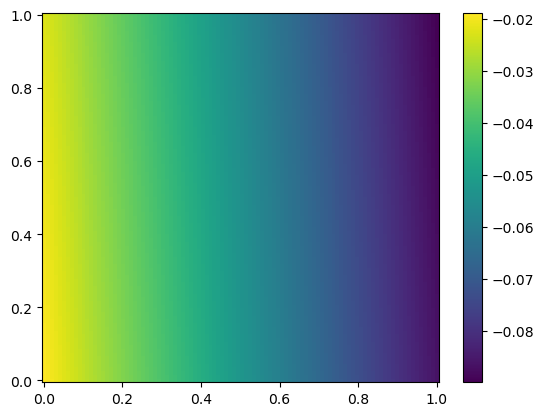

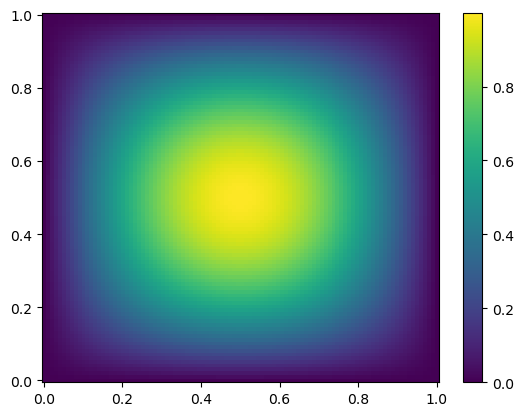

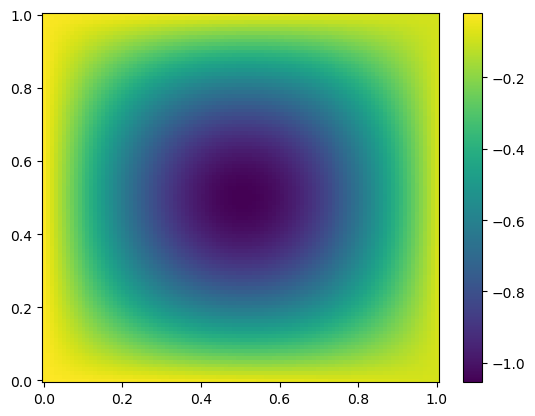

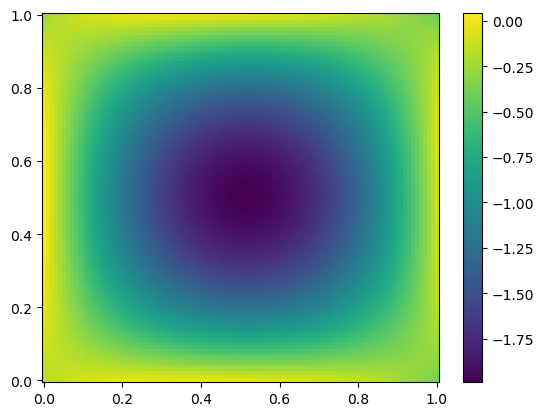

In [4]:
def wrap(func, *args):
    return jit(vmap(lambda x: func(x, *args), (0)))

# Evaluate
x = weak_integrator._x
y = v_model(param, x)
y_star = v_u_star(x)

grads = grad_loss(param)
nat_grads = nat_grad(param, grads)
dy = v_linearize(x, param, nat_grads)

plt.figure()
col = plot_2d_func(wrap(lambda x, par: model(par, x), param), interior, 100, ax=plt.gca())
plt.colorbar(col)

plt.figure()
col = plot_2d_func(v_u_star, interior, 100, ax=plt.gca())
plt.colorbar(col)

plt.figure()
col = plot_2d_func(wrap(lambda x, par: model(par, x) - u_star(x), param), interior, 100, ax=plt.gca())
plt.colorbar(col)

plt.figure()
col = plot_2d_func(wrap(linearize, param, nat_grads), interior, 100, ax=plt.gca())
plt.colorbar(col)